# Imports

In [1]:
# %matplotlib qt5

import numpy as np
import matplotlib.pyplot as plt
from mathphys.functions import load, save
from pycolleff.longitudinal_equilibrium import (
    ImpedanceSource,
    LongitudinalEquilibrium,
)

from pycolleff.rings import maxiv, als, half, sirius
from pycolleff.longitudinal_equilibrium import _mytrapz
from pycolleff.colleff import Ring

import matplotlib as mplt
import matplotlib.cm as cmap

from itertools import product

from functools import partial

# import scienceplots
# mplt.style.use("science")

plt.rcParams.update(
    {
        "font.size": 18,
        "axes.grid": True,
        "grid.linestyle": "--",
        "grid.alpha": 0.5,
    }
)

plt.rcParams["xtick.direction"] = "out"
plt.rcParams["ytick.right"] = False
plt.rcParams["ytick.direction"] = "out"
plt.rcParams["xtick.top"] = False

c = 299_792_458

# Methods

In [2]:
def calc_equilibrium_for_fixed_detuning(
    ring, hcav, current, detune, longeq=None, mcav=None, print_flag=False,
):
    """Calculate the equilibrium for a fixed cavity and current."""
    h = ring.harm_num
    ring.total_current = current
    fill = np.ones(h) / h
    
    if mcav is None:
        sources = [hcav]
    else:
        sources = [hcav, mcav]

    if longeq is None:
        longeq = LongitudinalEquilibrium(
            ring=ring,
            impedance_sources=sources,
            fillpattern=fill,
        )
        longeq.feedback_on = False
#         longeq.zgrid = np.linspace(-1, 1, 2001) * ring.rf_lamb / 2
        longeq.zgrid = np.linspace(-0.9, 0.9, 2001) * ring.rf_lamb/2
        longeq.identical_bunches = True
    else:
        longeq.ring = ring
        longeq.impedance_sources = sources
        longeq.ring.total_current = current
        longeq.fillpattern = fill

    longeq.impedance_sources[0].detune_w = 2 * np.pi * detune
    _ = longeq.calc_longitudinal_equilibrium(
        niter=1_000, tol=1e-8, beta=0.1, print_flag=print_flag, m=3
    )
    return longeq


def calc_equilibrium_for_flat_potential(
    ring, hcav, current, nr_iters=7, longeq=None, mcav=None, print_flag=False,
):
    """Calculate equilibrium to flat potential condition.

    This method will change the detune_angle of the cavity so that
    the beam induced voltage amplitude matches the flat potential
    condition.

    It will iterate a few times so that the form factor of the
    distribution converges.
    """
    h = ring.harm_num
    fill = np.ones(h) / h
    ring.total_current = current
    
    if mcav is None:
        sources = [hcav]
    else:
        sources = [hcav, mcav]

    if longeq is None:
        longeq = LongitudinalEquilibrium(
            ring=ring,
            impedance_sources=sources,
            fillpattern=fill,
        )
        longeq.feedback_on = False
        longeq.zgrid = np.linspace(-1, 1, 2001) * ring.rf_lamb / 4
        # longeq.zgrid = np.linspace(-0.9, 0.9, 2001) * ring.rf_lamb/2
        longeq.identical_bunches = True
    else:
        longeq.ring = ring
        longeq.impedance_sources = sources,
        longeq.ring.total_current = current
        longeq.fillpattern = fill

    for _ in range(nr_iters):
        kharm = longeq.calc_harmonic_voltage_for_flat_potential()
        vharm = kharm * longeq.ring.gap_voltage
        angle = longeq.calc_detune_for_fixed_harmonic_voltage(
            vharm, Rs=hcav.shunt_impedance
        )
        hcav.detune_angle = angle
        longeq.impedance_sources[0] = hcav
        print(f"detune: {hcav.detune_w/2/np.pi/1e3:.3f} kHz")

        _ = longeq.calc_longitudinal_equilibrium(
            niter=1000, tol=1e-8, beta=0.1, print_flag=print_flag, m=3
        )
    return longeq


###############################################################################
def calc_lmci(
    longeq,
    cbmode=1,
    max_azi=2,
    max_rad=1,
    use_fokker=True,
    delete_m0=False,
    delete_m0k0=True,
    reduced=False,
    print_flag=False,
):
    """Calculate LMCI for a given coupled bunch mode and equilibrium condition.

    Args:
        longeq: object from Longitudinal equilibrium class;
        cbmode: coupled-bunch mode to evaluate must be in range [0, h-1].
            Defaults to 1, which is the mode of PTBL instability;
        max_azi: maximum azimuthal mode to consider in expansion.
            Detaults to 2. Found to be enough to explain PTBL instability;
        max_azi: maximum radial mode to consider in expansion. Defaults to 1.
            Also found to be enough to explain PTBL instability.

    Returns:
        eigenfreq: complex coherent eigen angular frequencies in [rad/s];
        freqshift: frequency of the most unstable mode in [Hz];
        grate: growth rate of the most unstable mode in [1/s];
        sync_freq: incoherent synchrotron frequency used in calculations [Hz];
        peak_hvolt: peak voltage of harmonic cavity [V].

    """
    for idx, _ in enumerate(longeq.impedance_sources):
        longeq.impedance_sources[idx].calc_method = ImpedanceSource.Methods.ImpedanceDFT
        longeq.impedance_sources[idx].active_passive = ImpedanceSource.ActivePassive.Passive
    
    hcav = longeq.impedance_sources[0]
    hvolt = longeq.calc_induced_voltage_wake(
        dist=longeq.distributions, wake_source=hcav
    )
    mvolt = longeq.main_voltage
    tvolt = mvolt + hvolt
    peak_hvolt = np.max(np.abs(hvolt[0, :]))
    peak_mvolt = np.max(np.abs(mvolt))
    
    if print_flag:
        print(f"current: {longeq.ring.total_current*1e3:.2f} mA")
        print(f"detune: {hcav.detune_w/2/np.pi/1e3:.3f} kHz")
        print(f"detune angle: {np.rad2deg(hcav.detune_angle):.1f} deg")
        print(f"R/Q: {hcav.shunt_impedance/hcav.Q:.1f} Ohm")
        print(f"HC voltage: {peak_hvolt/1e3:.1f} kV")
        ratio = peak_hvolt / peak_mvolt
        print(f"HC voltage ratio: {ratio:.3f}")

    wrf = longeq.ring.rf_ang_freq
    dist, pot = longeq.calc_distributions_from_voltage(longeq.total_voltage)
    z0, sigmaz = longeq.calc_moments(longeq.zgrid, dist[0])
    sigmaz = sigmaz[0]

    # Calculate the equivalent synchrotron frequency:
    # Equivalent single-rf (quadratic) potential.
#     Sync. frequency determined by bunch length
    sync_freq = longeq.ring.espread * longeq.ring.mom_comp * c
    sync_freq /= sigmaz * 2 * np.pi
    if print_flag:
        print(f"FREQ BY BUNCH LENGTH: {sync_freq:.5f} Hz")

# #     Sync. freq. by voltage derivative average by distribution
#     longeq.calc_synchrotron_frequency(
#         tvolt, method='derivative', nrpts=500, max_amp=5)
#     sync_data = longeq.equilibrium_info
#     sync_freq = sync_data['avg_sync_freq']
#     print(f"FREQ BY V'(z): {sync_freq:.5f} Hz")

#     # Amplitude-dependent Sync. freq. averaged by action distribution
#     sync_data = longeq.calc_synchrotron_frequency(
#         method='action', nrpts=500, max_amp=5)
#     sync_freq = sync_data['avg_sync_freq']
#     print(f"FREQ BY w(J): {sync_freq:.5f} Hz")

    longeq.ring.sync_tune = sync_freq / longeq.ring.rev_freq
    longeq.ring.bunlen = sigmaz
    
    if print_flag:
        print(
            f"sync. freq.: {longeq.ring.sync_tune * longeq.ring.rev_freq:.3f} Hz"
        )
        print(f"bunch length: {longeq.ring.bunlen*1e3:.3f} mm")

    # Calculate Vlasov's equation eigen-frequencies:
    wrf = longeq.ring.rf_ang_freq
    eigenfreq, *_ = longeq.calc_mode_coupling(
        w=[-10 * wrf, +10 * wrf],
        cbmode=cbmode,
        max_azi=max_azi,
        max_rad=max_rad,
        use_fokker=use_fokker,
        delete_m0=delete_m0,
        delete_m0k0=delete_m0k0,
        reduced=reduced,
    )

    # Find most unstable mode:
    idx = np.argmax(eigenfreq.imag)
    freqshift = eigenfreq.real[idx] / 2 / np.pi
    grate = eigenfreq.imag[idx]
    if reduced:
        # Subtract radiation damping rate from "reduced" simulation:
        grate -= 1 / longeq.ring.dampte
    
    if print_flag:
        print("Most unstable mode:")
        print(f"    frequency: {freqshift:.2f} Hz")
        print(f"    growth rate: {grate:.2f} 1/s")
        print("\n")
    return eigenfreq, freqshift, grate, sync_freq, peak_hvolt

def calc_lmci_scan_detuning(
    ring,
    hcav,
    current,
    detuning_scan,
    cbmode=0,
    max_azi=3,
    max_rad=2,
    mcav=None,
    use_fokker=True,
    delete_m0=False,
    delete_m0k0=True,
    reduced=False,
    stop_when_unstable=False,
    print_flag=False,
):
    """Calculate equilibrium and solve Vlasov equation for a detuning set."""
    growths, shifts, syncdata, peak_hvolts = [], [], [], []
    longeq = None
    # cbmode = ring.harm_num-1
    eigs = []
        
    for i, detune in enumerate(detuning_scan):
        longeq = calc_equilibrium_for_fixed_detuning(
            ring=ring,
            hcav=hcav,
            mcav=mcav,
            current=current,
            detune=detune,
            longeq=longeq,
            print_flag=print_flag,
        )
        eigenfreq, tuneshift, grate, sync_freq, peak_hvolt = calc_lmci(
            longeq,
            cbmode=cbmode,
            max_azi=max_azi,
            max_rad=max_rad,
            use_fokker=use_fokker,
            delete_m0=delete_m0,
            delete_m0k0=delete_m0k0,
            reduced=reduced,
            print_flag=print_flag,
        )
        growths.append(grate)
        shifts.append(tuneshift)
        syncdata.append(sync_freq)
        peak_hvolts.append(peak_hvolt)
        eigs.append(eigenfreq)
        
        if stop_when_unstable and grate > 0:
            break
    growths = np.array(growths)
    shifts = np.array(shifts)
    syncdata = np.array(syncdata)
    peak_hvolts = np.array(peak_hvolts)
    return growths, shifts, syncdata, peak_hvolts, eigs

In [3]:
def transfer_func(w, wrf, gain=1, kp=1, ki=1, kd=0, delay=0):
    phase = wrf*delay
    exp_delay = np.exp(-1j*delay*w)
    exp_phase = np.exp(1j*phase)    
    eps = 1e-16
    pid_ctrl = kp + ki / 1j / (w-wrf+eps) + kd * 1j * (w-wrf)
    transfer = gain * pid_ctrl * exp_delay * exp_phase
    return transfer

# MAX-IV

In [4]:
ring = maxiv.create_ring(energy=3)
# ring.gap_voltage = 1.397e6

ring.gap_voltage = 0.650e6
ring.total_current = 50e-3
# ring.total_current = 300e-3

# ring.gap_voltage = 0.689e6
# ring.total_current = 90e-3

# ring.gap_voltage = 650e3
# ring.total_current = 50e-3
print(ring)

Lattice Version             :     MAX-IV-3GeV     
Circumference [m]           :       527.999       
Revolution Period [us]      :        1.761        
Revolution Frequency [kHz]  :       567.790       
Energy [GeV]                :        3.000        
U0 [keV]                    :       363.800       
Vgap [MV]                   :        0.650        
Momentum Compaction         :       3.06e-04      
Harmonic Number             :         176         
Current [mA]                :        50.000       
Current per Bunch [mA]      :        0.284        
Synchrotron Tune            :       0.00164       
Tunes x/y                   :    16.280/42.200    
Chromaticities x/y          :     1.000/1.000     
Damping Times x/y/e [ms]    :   15.7/ 29.0 /25.2  
Energy Spread [%]           :        0.0769       
Bunch Length [mm]           :        10.694       



In [5]:
hcav = ImpedanceSource()
hcav.harm_rf = 3
hcav.Q = 20_800
ncavs = 3

# simulating 2 harmonic cavities
# ncavs = 2

hcav.shunt_impedance = 2.75e6 * ncavs

twopi = 2 * np.pi
hcav.ang_freq_rf = twopi * ring.rf_freq
hcav.ang_freq = hcav.harm_rf * hcav.ang_freq_rf

hcav.detune_w = twopi * 85e3
# hcav.calc_method = ImpedanceSource.Methods.ImpedanceDFT
hcav.calc_method = ImpedanceSource.Methods.Wake
hcav.active_passive = ImpedanceSource.ActivePassive.Passive

In [6]:
def create_mc(current, ring):
    Q = 3688.0
    Rs = 1.552e6 * 6 # [Ohm]
    # detune_mc = -8e3  # [Hz]  # for 300mA
    ratio = -8e3/300e-3
    detune_mc = ratio * current  # [Hz]
    harm_rf = 1

    mcav = ImpedanceSource()
    mcav.harm_rf = harm_rf
    mcav.Q = Q
    mcav.shunt_impedance = Rs

    # ring = maxiv.create_ring(energy=energy)
    wrf = ring.rf_ang_freq
    mcav.ang_freq_rf = wrf
    mcav.ang_freq = mcav.harm_rf*wrf + 2*np.pi*detune_mc

#     mcav.calc_method = ImpedanceSource.Methods.Wake
    mcav.calc_method = ImpedanceSource.Methods.ImpedanceDFT
    mcav.active_passive = ImpedanceSource.ActivePassive.Active

    mcav.loop_ctrl_ang_freq = wrf
    mcav.loop_ctrl_transfer = partial(transfer_func, gain=1, kp=0, ki=1, kd=0, delay=0)
    mcav.loop_ctrl_freq = wrf/2/np.pi
    return mcav

In [7]:
current = 50e-3
# current = 90e-3
# current = 300e-3
mcav = create_mc(current, ring)
# mcav.shunt_impedance = 0

In [8]:
longeq = calc_equilibrium_for_flat_potential(ring, hcav, mcav=mcav, current=current)

detune: 33.156 kHz
detune: 31.436 kHz
detune: 30.829 kHz
detune: 30.565 kHz
detune: 30.442 kHz
detune: 30.383 kHz
detune: 30.354 kHz


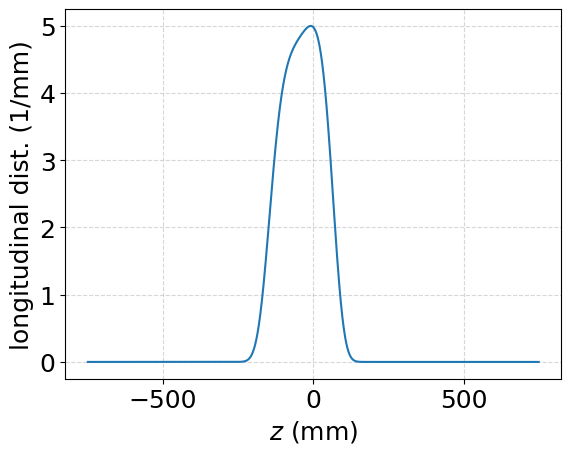

In [9]:
plt.figure()
plt.plot(longeq.zgrid*1e3, longeq.distributions[0])
plt.xlabel("$z$ (mm)")
plt.ylabel("longitudinal dist. (1/mm)")
plt.show()

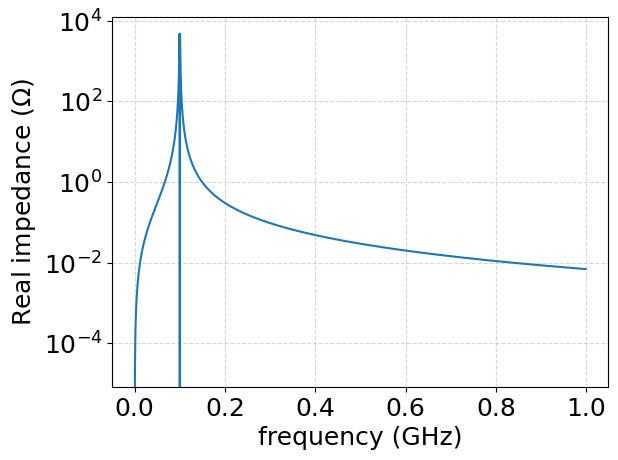

In [10]:
plt.figure()
w = longeq._create_freqs()
plt.plot(w/2/np.pi*1e-9, longeq.get_impedance(apply_filter=True).real)
plt.xlabel("frequency (GHz)")
plt.ylabel(r"Real impedance ($\Omega$)")
plt.yscale('log')
plt.show()

In [11]:
detune_scan = np.linspace(75, 30, 1000) * 1e3
current = 50e-3

# detune_scan = np.linspace(90, 50, 10) * 1e3
# current = 90e-3


# detune_scan = np.linspace(500, 150, 500) * 1e3
# current = 300e-3

mcav = create_mc(current, ring)
mcav.shunt_impedance = 0

# plt.figure()
# w = longeq._create_freqs()
# plt.plot(w/2/np.pi*1e-9, longeq.get_impedance(apply_filter=True).real)
# plt.yscale('log')
# plt.show()

grate, freq, sync_freq, peak_hvolt, eigs = calc_lmci_scan_detuning(
    ring,
    hcav,
    current,
    detune_scan,
    max_azi=2,
    max_rad=0,
    cbmode=0,
    mcav=mcav,
#     mcav = None,
    use_fokker=True,
    delete_m0=True,
    delete_m0k0=True,
    reduced=False,
    stop_when_unstable=False,
    print_flag=False,
)

eigs = np.array(eigs)

In [12]:
# The actual HC fields seems to be 7% lower than the measured by the probe. 
# 3 cavities
hc_field = 3 * np.array([
    30, 35, 40, 42, 44, 
    46, 48, 50, 52, 55, 
    56, 58, 60]) / 1.07

mode0_dip = np.array([
    680.2, 680.2, 680.2, 680.2, 680.2,
    680.2, 680.2, 680.2, 680.2, 658.5,
    658.5, 658.5, 644.0,])

mode0_quad = np.array([
    1027.5, 955.14, 875.54, 832.13, 795.95,
    781.48, 600.58, np.nan, np.nan, 600.58,
    607.81, 535.46, 528.22])

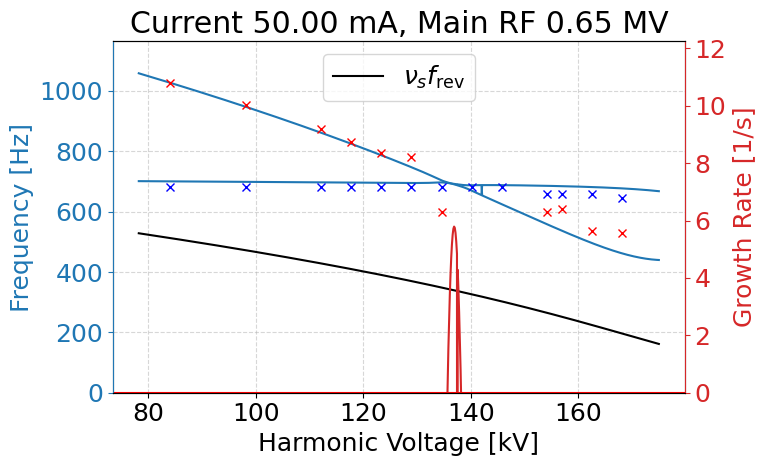

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ay = ax.twinx()

# current = 50e-3
norm = 1
# ax.plot(peak_hvolt * 1e-3 / norm, freq, "o-")

ax.plot(peak_hvolt * 1e-3 / norm, eigs.real/2/np.pi, ls="-", color="tab:blue")

ax.plot(hc_field, mode0_dip, "x", color="b")
ax.plot(hc_field, mode0_quad, "x", color="r")

ax.plot(peak_hvolt * 1e-3 / norm, sync_freq, color="k", label=r"$\nu_sf_{\text{rev}}$")
ax.set_ylim(bottom=0)

# ay.plot(peak_hvolt * 1e-3 / norm, grate, "o-", color="tab:red")
ay.plot(peak_hvolt * 1e-3 / norm, eigs.imag, ls="-", color="tab:red")
ay.set_ylim(bottom=0)

ay.axhline(0, color='r')
ax.set_title(f"Current {current*1e3:.2f} mA, Main RF {ring.gap_voltage/1e6:.2f} MV")
# ax.axvline(448.181)

ay.grid(False)
ay.spines["right"].set_color("tab:red")
# plt.setp(ay.yaxis.get_ticklabels(), color='tab:red')
ay.tick_params(axis="y", colors="tab:red")

ay.spines["left"].set_color("C0")
plt.setp(ax.yaxis.get_ticklabels(), color="tab:red")
ax.tick_params(axis="y", colors="C0")

ax.legend(loc="upper center", frameon=True)
ax.set_ylabel("Frequency [Hz]", color="C0")
ax.set_xlabel("Harmonic Voltage [kV]")
ay.set_ylabel("Growth Rate [1/s]", color="tab:red")
fig.tight_layout()
plt.show()